# Movie Recommendation system based on IMDBMovieData (Content based)

- Problem Statement:

Build a content based recommendation system to recommend 10 movies to the client  


In [ ]:
import pandas as pd
import numpy as np
import os
from rake_nltk import Rake 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import seaborn as sns
import matplotlib.pyplot as plt

### Load the DataSet

In [3]:
csvFilePath = os.getcwd()

In [4]:
dataFrame = pd.read_csv(filepath_or_buffer="DataSet/IMDBMovieData.csv",encoding = 'unicode_escape')

In [5]:
dataFrame.head(5)

,ID,Title,Genre,Description,Director,Actors,Year,Runtime,Rating,Votes,Revenue,Metascore
0,1.0,Guardians of the Galaxy,"Action,Adventure,Sci-Fi",A group of intergalactic criminals are forced ...,James Gunn,"Chris Pratt, Vin Diesel, Bradley Cooper, Zoe S...",2014,121.0,8.1,757074.0,333.13,76.0
1,2.0,Prometheus,"Adventure,Mystery,Sci-Fi","Following clues to the origin of mankind, a te...",Ridley Scott,"Noomi Rapace, Logan Marshall-Green, Michael Fa...",2012,124.0,7.0,485820.0,126.46,65.0
2,3.0,Split,"Horror,Thriller",Three girls are kidnapped by a man with a diag...,M. Night Shyamalan,"James McAvoy, Anya Taylor-Joy, Haley Lu Richar...",2016,117.0,7.3,157606.0,138.12,62.0
3,4.0,Danny Collins,"Drama,Music",NaN,Dan Fogelman,"Al Pacino, Jennifer Garner, Annette Bening",2015,NaN,7.0,NaN,NaN,NaN
4,4.0,Sing,"Animation,Comedy,Family","In a city of humanoid animals, a hustling thea...",Christophe Lourdelet,"Matthew McConaughey,Reese Witherspoon, Seth Ma...",2016,108.0,7.2,60545.0,270.32,59.0


### For this problem I want to limit to features mentioned below for the recommendation system
- Genre
- Description 
- Director
- Actors


In [8]:
Movie_Names = dataFrame.Title

In [9]:
Movie_Names.shape

(1004,)

In [10]:
dataFrame = dataFrame.drop(['Title', 'ID', 'Votes', 'Year', 'Revenue','Metascore', 'Rating','Runtime'], axis=1)

In [11]:
dataFrame.columns

Index(['Genre', 'Description', 'Director', 'Actors'], dtype='object')

## Data Pre-processing

- Create dummies for each "Gere"
- Create dummies for each "Director"
- Create dummies for each "Actors"
- From "Description" extract key words and build corpse

### Pre-process Genre

In [12]:
df_Genre = dataFrame.Genre

In [13]:
df_Genre = df_Genre.str.get_dummies(',')

In [14]:
df_Genre.columns

Index(['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Musical',
       'Mystery', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western'],
      dtype='object')

In [15]:
df_Genre.dtypes

Action       int64
Adventure    int64
Animation    int64
Biography    int64
Comedy       int64
Crime        int64
Drama        int64
Family       int64
Fantasy      int64
History      int64
Horror       int64
Music        int64
Musical      int64
Mystery      int64
Romance      int64
Sci-Fi       int64
Sport        int64
Thriller     int64
War          int64
Western      int64
dtype: object

In [16]:
df_Genre.shape

(1004, 20)

In [17]:
df_Genre.head(5)

,Action,Adventure,Animation,Biography,Comedy,Crime,Drama,Family,Fantasy,History,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
4,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


### Pre-process Directors

In [18]:
df_Directors = dataFrame.Director

In [19]:
df_Directors.isnull().values.any()

False

In [20]:
df_Directors = df_Directors.str.get_dummies(',')

In [21]:
df_Directors.columns

Index(['Aamir Khan', 'Abdellatif Kechiche', 'Abrams', 'Adam Leon',
       'Adam Mazer', 'Adam McKay', 'Adam Shankman', 'Adam Wingard',
       'Afonso Poyart', 'Aisling Walsh',
       ...
       'Will Gluck', 'Will Slocombe', 'William Brent Bell', 'William Oldroyd',
       'Woody Allen', 'Xavier Dolan', 'Yimou Zhang', 'Yorgos Lanthimos',
       'Zack Snyder', 'Zackary Adler'],
      dtype='object', length=651)

In [22]:
df_Directors.isnull().values.any()

False

In [23]:
df_Directors.head(5)

,Aamir Khan,Abdellatif Kechiche,Abrams,Adam Leon,Adam Mazer,Adam McKay,Adam Shankman,Adam Wingard,Afonso Poyart,Aisling Walsh,...,Will Gluck,Will Slocombe,William Brent Bell,William Oldroyd,Woody Allen,Xavier Dolan,Yimou Zhang,Yorgos Lanthimos,Zack Snyder,Zackary Adler
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Preprocess Actors

In [24]:
df_Actors = dataFrame.Actors

In [25]:
df_Actors.isnull().values.any()

False

In [26]:
df_Actors.dtype

dtype('O')

In [27]:
df_Actors = df_Actors.str.get_dummies(',')

In [28]:
df_Actors.columns

Index([' 50 Cent', ' A.C. Peterson', ' AJ Michalka', ' Aamir Khan',
       ' Aaron Burns', ' Aaron Eckhart', ' Aaron Paul',
       ' Aaron Taylor-Johnson', ' Aaron Yoo', ' Aasif Mandvi',
       ...
       'Winona Ryder', 'Woody Allen', 'Xavier Samuel', 'Yoo Gong', 'Zac Efron',
       'Zach Galifianakis', 'Zachary Gordon', 'Zachary Quinto', 'Zoey Deutch',
       'Zooey Deschanel'],
      dtype='object', length=2359)

In [29]:
df_Actors.shape

(1004, 2359)

### Pre-Process Description
- Tfidf is used to get imporatnt words out of the description provided for the movie

In [30]:
df_Description = dataFrame.Description

In [31]:
df_Description.isnull().values.any()

True

In [32]:
df_Description.head(5)

0    A group of intergalactic criminals are forced ...
1    Following clues to the origin of mankind, a te...
2    Three girls are kidnapped by a man with a diag...
3                                                  NaN
4    In a city of humanoid animals, a hustling thea...
Name: Description, dtype: object

In [33]:
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0, stop_words='english')

In [34]:
tf_DataFrame = pd.SparseDataFrame(data=tf.fit_transform(df_Description.values.astype('U')),columns=tf.get_feature_names(), 
                                   default_fill_value=0)


In [35]:
tf_DataFrame.head(5)

,000,000 head,000 head cattle,000 savings,000 savings account,000 slaves,000 slaves monumental,007,007 defeat,007 defeat weapons,...,zone triggering,zone triggering international,zone world,zone world capture,zubrowka,zubrowka second,zubrowka second world,zuckerberg,zuckerberg creates,zuckerberg creates social
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Create dataFrame with all Genre, Actors, Directors and Words from Description

In [36]:
tf_DataFrame.shape

(1004, 32178)

In [37]:
df_Actors.shape

(1004, 2359)

In [38]:
df_Genre.shape

(1004, 20)

In [39]:
df_Directors.shape

(1004, 651)

In [40]:
final_DataFrame = pd.concat([df_Genre,df_Actors,df_Directors,tf_DataFrame],axis = 1)

In [41]:
final_DataFrame.shape

(1004, 35208)

### Cosine Similarities

Since we have 1004 movies in the dataset so final cosine matrix would be a matrix of size 1004 * 1004

In [42]:
cosine_sim = cosine_similarity(final_DataFrame,final_DataFrame)

In [51]:
cosine_sim 

array([[1.        , 0.22222222, 0.        , ..., 0.        , 0.11785113,
        0.        ],
       [0.22222222, 1.        , 0.        , ..., 0.        , 0.11785113,
        0.00155016],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.11785113, 0.11785113, 0.        , ..., 0.        , 1.        ,
        0.11785113],
       [0.        , 0.00155016, 0.        , ..., 0.        , 0.11785113,
        1.        ]])

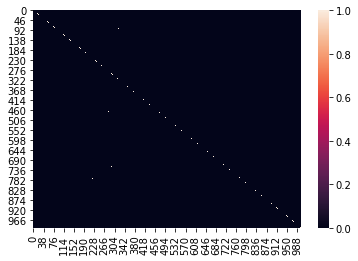

In [63]:
sns.heatmap(cosine_sim>0.6)

In [71]:
cosine_sim.shape

(1004, 1004)

## From the cosin matrix extract top 10 movies to be recommended and store the result

In [74]:
results = {}

for i,rows in Movie_Names.iteritems():
    topSortedMovies = cosine_sim[i].argsort()[:-10:-1]
    similar_items = [(Movie_Names[ix],cosine_sim[i][ix]) for ix in topSortedMovies]
    
    results[Movie_Names[i]] = similar_items[:]
        

In [92]:
for i in Movie_Names:
    print(i)

Guardians of the Galaxy
Prometheus
Split
Danny Collins
Sing
Suicide Squad
The Great Wall
La La Land
Mindhorn
The Lost City of Z
Passengers
Fantastic Beasts and Where to Find Them
Hidden Figures
Rogue One
Moana
Colossal
The Secret Life of Pets
You Don't Know Jack
Hacksaw Ridge
Jason Bourne
Lion
Arrival
Gold
Manchester by the Sea
Hounds of Love
Trolls
Independence Day: Resurgence
Paris pieds nus
Bahubali: The Beginning
Dead Awake
Bad Moms
Assassin's Creed
Why Him?
Nocturnal Animals
X-Men: Apocalypse
Deadpool
Resident Evil: The Final Chapter
Captain America: Civil War
Interstellar
Doctor Strange
The Magnificent Seven
5/25/77
Sausage Party
Moonlight
Don't Fuck in the Woods
The Founder
Lowriders
Pirates of the Caribbean: On Stranger Tides
Miss Sloane
Fallen
Star Trek Beyond
The Last Face
Star Wars: Episode VII - The Force Awakens
Underworld: Blood Wars
Mother's Day
John Wick
The Dark Knight
Silence
Don't Breathe
Me Before You
Their Finest
Sully
Batman v Superman: Dawn of Justice
The Autopsy

## Test the context based recommendation system

In [93]:
results['Captain America: Civil War']

[('Captain America: Civil War', 1.0000000000000016),
 ('Captain America: The Winter Soldier', 0.6666666666666682),
 ('Captain America: The First Avenger', 0.45605866972695525),
 ('Battleship', 0.35355339059327423),
 ('The 5th Wave', 0.353553390593274),
 ('Iron Man 2', 0.34090281113536997),
 ('Star Trek Into Darkness', 0.33635511963639253),
 ('The Amazing Spider-Man 2', 0.3342501720118544),
 ('Batman v Superman: Dawn of Justice', 0.3341246116649972)]

In [94]:
results['The Dark Knight']

[('The Dark Knight', 0.9999999999999993),
 ('London Has Fallen', 0.444444444444444),
 ('The Dark Knight Rises', 0.3628203424519297),
 ('American Hustle', 0.3535533905932736),
 ('Chappie', 0.3352760254136754),
 ('Gangster Squad', 0.3333333333333339),
 ('Public Enemies', 0.3333333333333336),
 ('Faster', 0.33333333333333354),
 ('The Gunman', 0.3333333333333334)]

In [98]:
results['The Avengers']

[('The Avengers', 0.9999999999999993),
 ('Avengers: Age of Ultron', 0.6021513119189141),
 ('Iron Man', 0.35487993004745433),
 ('Iron Man 2', 0.35355339059327373),
 ('Iron Man Three', 0.3535533905932736),
 ('The 5th Wave', 0.2534349555921064),
 ("Ender's Game", 0.25297390013203985),
 ('Riddick', 0.2514647915509955),
 ('Battleship', 0.25000000000000006)]